In [12]:
import argparse
import logging
import numpy as np
import os
from tqdm import tqdm

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from scipy.sparse import csr_matrix

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--train_path', type=str, default='/media/vutrungnghia/New Volume/DSLab/datasets/train_tf_idf.txt')
parser.add_argument('--test_path', type=str, default='/media/vutrungnghia/New Volume/DSLab/datasets/test_tf_idf.txt')
parser.add_argument('--word_idfs_path', type=str, default='/media/vutrungnghia/New Volume/DSLab/datasets/words_idfs.txt')
args = parser.parse_args([])


In [3]:
def load_data(data_path, word_idfs_path):
    def sparse_to_dense(sparse_rd, vocab_size):
        r_d = [0.0] * vocab_size
        indices_tfidfs = sparse_rd.split()
        for index_tfidf in indices_tfidfs:
            index = int(index_tfidf.split(':')[0])
            tfidf = float(index_tfidf.split(':')[1])
            r_d[index] = tfidf
        return np.array(r_d)

    with open(data_path) as f:
        d_lines = f.read().splitlines()

    with open(word_idfs_path) as f:
        vocab_size = len(f.read().splitlines())

    data = []
    labels = []
    for d in tqdm(d_lines):
        features = d.split('<fff>')
        label, _ = int(features[0]), int(features[1])
        labels.append(label)
        r_d = sparse_to_dense(sparse_rd=features[2], vocab_size=vocab_size)
        data.append(r_d.reshape(1, r_d.shape[0]))

    data = np.concatenate(data, axis=0)
    return data, np.array(labels)

# K-means

In [4]:
data, labels = load_data(args.train_path, args.word_idfs_path)
X = csr_matrix(data)

100%|██████████| 11314/11314 [00:11<00:00, 1008.90it/s]


In [5]:
kmeans = KMeans(
    n_clusters=20,
    init='random',
    n_init=5,
    tol=12-3,
    random_state=2048
).fit(X)

In [6]:
pred_labels = kmeans.labels_
print(f'NMI metric: {normalized_mutual_info_score(labels, pred_labels)}')

NMI metric: 0.44821877759542217


# SVM

In [10]:
def get_cmap(n):
    return 'C' + str(n)

def plot_learning_curve(estimator, title, label_curve, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), new_plot=False,
                        idx_color=0):
    
    if new_plot:
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Accuracy")
        plt.grid()
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    color = get_cmap(idx_color)
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color=color)
    plt.plot(train_sizes, test_scores_mean, 'o-', color=color,
             label=label_curve)

    plt.legend(loc="best")
    return plt

In [8]:
X_train, Y_train = load_data(args.train_path, args.word_idfs_path)
X_test, Y_test = load_data(args.test_path, args.word_idfs_path)

100%|██████████| 7532/7532 [00:07<00:00, 966.18it/s] 


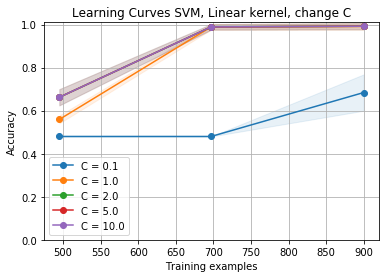

In [13]:
title = "Learning Curves SVM, Linear kernel, change C"

for i, C in enumerate([.1, 1.0, 2.0, 5.0, 10.0]):

    text_clf = Pipeline([('clf', svm.SVC(kernel='rbf', C=C)),
                         ])
    
    plt = plot_learning_curve(text_clf, title, "C = %0.1f" % (C),
                              csr_matrix(X_train[0:1000]), Y_train[0:1000],
                              (0.0, 1.01), cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)

plt.savefig(os.path.join('hyperparameter_C.png'), bbox_inches='tight')
plt.show()

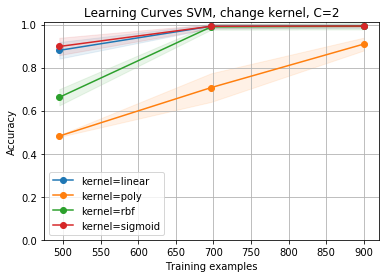

In [15]:
title = "Learning Curves SVM, change kernel, C=2"

for i, kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):

    text_clf = Pipeline([('clf', svm.SVC(kernel=kernel, C=2)),
                         ])
    
    plt = plot_learning_curve(text_clf, title, f"kernel={kernel}",
                              csr_matrix(X_train[0:1000]), Y_train[0:1000],
                              (0.0, 1.01), cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)

plt.savefig(os.path.join('hyperparameter_kernel.png'), bbox_inches='tight')
plt.show()

In [16]:
model = svm.SVC(kernel='rbf', C=2, verbose=True)
model.fit(csr_matrix(X_train), Y_train)

[LibSVM]

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

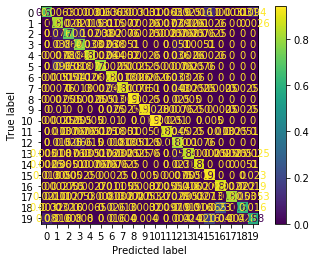

In [17]:
plot_confusion_matrix(model, csr_matrix(X_test), Y_test, normalize='true')

In [18]:
predictions = model.predict(csr_matrix(X_test))
acc = (Y_test == predictions).sum()/len(predictions)
print(acc)

0.8255443441317047
